# Simulated base inference of SEEG signals using 2D VEP model

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp


import numba
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import colors, cm

In [2]:
import torch
import sbi 
import sbi.utils as utils
from sbi.inference.base import infer

from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn

In [3]:
from sklearn.metrics import confusion_matrix
from BVEP_SME import SME_labels, SEM_violinplot, plot_confusion_matrix, plot_zscore_shrinkage, plot_roc_curve, true_node_binary, estimated_node_binary, SME_accuracy

In [4]:
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [5]:
import warnings
warnings.simplefilter("ignore")

In [6]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [7]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on sbi: v{}'.format(sbi.__version__))

Running on numpy: v1.18.4
Running on torch: v1.6.0
Running on sbi: v0.12.2


In [8]:
cwd = os.getcwd()
cwd

'/data/SBI/BVEP_SBI'

In [9]:
Res_dir='Res_BVEP_sde_sensitivity_seeg_GrExp_patient1'

### Constants

In [10]:
I1=3.1
eta_c=-2.05        
delta_eta=1.0                  
prior_std =1.0
sd_thr=0.8

# Patient CJ

In [11]:
cwd = os.getcwd()
cwd

'/data/SBI/BVEP_SBI'

## Structural Connectivity and Gain Matrices

In [12]:
weights = np.loadtxt(os.path.join(cwd+"/ExperimentalData_CJ", "weights.txt"))

In [13]:
# normalize Connectome
weights = weights/np.max(weights)
num_regions = len(weights)

In [14]:
weights.min(), weights.max()

(0.0, 1.0)

In [15]:
Gr = np.loadtxt(os.path.join(cwd+"/ExperimentalData_CJ", "gain_inv-square.txt"))

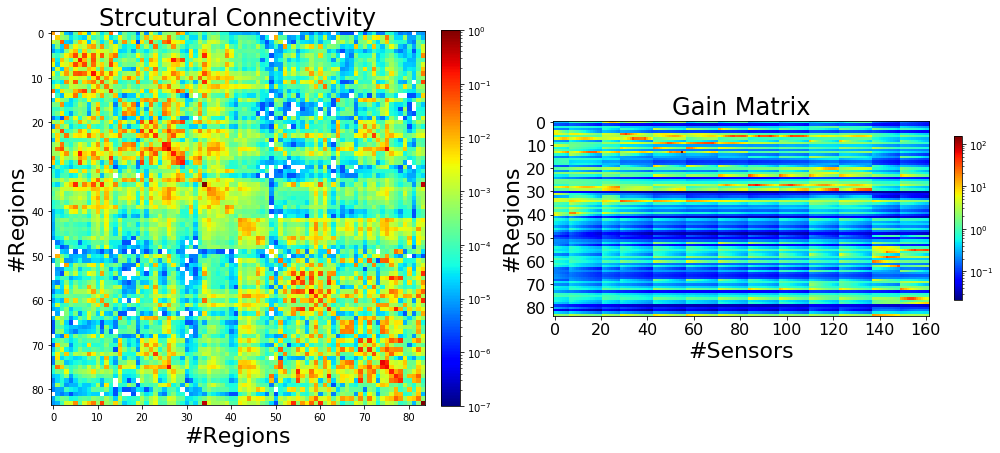

In [16]:
plt.figure(figsize=(14, 8))
plt.subplot(121)
norm = colors.LogNorm(1e-7, weights.max())
im = plt.imshow(weights,norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Strcutural Connectivity', fontsize=24.0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Regions', fontsize=22.0)

plt.subplot(122)
norm = colors.LogNorm(Gr.min(), Gr.max())
im = plt.imshow(Gr.transpose(),norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.02, pad=0.06)
plt.gca().set_title('Gain Matrix', fontsize=24.0)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16, rotation=0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Sensors', fontsize=22.0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SC_GainMatrix.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SC_GainMatrix.eps"), doi=800)
plt.show()

## ROIs chosen as Epileptogenic/propagation zones

In [17]:
hz_val=-3.65
pz_val=-2.4
ez_val=-1.6

ez_idx = np.array([6, 34],  dtype=np.int32)
pz_wplng_idx = np.array([5,11], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [ ]:
#Here, confidential medical information

In [19]:
SC=weights
SC.shape

(84, 84)

### Selected nodes and contacts

In [20]:
contacts = []
with open(cwd+ '/ExperimentalData_CJ/complex_raw.ades', 'r') as fd:
    for line in fd.readlines():
        parts = [p.strip() for p in line.strip().split('=')]
        if len(parts)>1 and parts[1] == 'SEEG':
            name, idx = re.match("([A-Z]+[a-z]*[']*)([0-9]+)", parts[0]).groups()
            idx = int(idx)
            contacts.append((name, idx)) 

In [21]:
reg_xyz = np.loadtxt(cwd+ '/ExperimentalData_CJ/centers.txt', usecols=(1,2,3))

reg_names = []
with open(cwd+ '/ExperimentalData_CJ/centers.txt', 'r') as fd:
    #for line in fd.readlines():
     #   reg_names.append(line.strip().split()[0])
    for i, line in enumerate(fd.readlines()):
        reg_names.append('r%03d-%s' % (i, line.strip().split()[0]))
#seg = nibabel.load('aparcaseg_2_diff_2.nii.gz')
#reg_xyz = seg.affine.dot(c_[reg_xyz, ones((reg_xyz.shape[0], ))].T)[:3].T

In [22]:
seeg_xyz = np.loadtxt(cwd+ '/ExperimentalData_CJ/elecs_name.txt', usecols=(1,2,3))

seeg_labels = []

with open(cwd+ '/ExperimentalData_CJ/elecs_name.txt', 'r') as fd:
    for line in fd.readlines():
        parts = line.strip().split()
        seeg_labels.append(parts[0].upper())
#print sorted(seeg_labels+[e+str(i) for e, i in contacts])
monopolar_chan_to_pos = []
for name, idx in contacts:
    monopolar_chan_to_pos.append(seeg_labels.index(name+str(idx)))
seeg_xyz = np.array([seeg_xyz[i] for i in monopolar_chan_to_pos])

In [23]:
ez_idx, pz_idx

(array([ 6, 34], dtype=int32), array([27,  5, 11], dtype=int32))

In [24]:
selectednodes=np.array([ 5,  6,  11,  27, 34])
r_selectednodes=reg_xyz[selectednodes]

Ps=np.array([] ) 

selectedcontacts=[bipnames[c] for c in Ps]

ss=[]
sss=[]
for s in selectedcontacts:
    parts = s.strip().split('-')
    name, idx=re.match("([A-Za-z]+[']*)([0-9]+)", s).groups()
    idx = int(idx)
    #sss.append((name, idx))
    ss.append(parts[0].upper())
    
    
selectedcontacts_indices=[contacts_labels.index(c) for c in ss] 
r_selectedcontacts=seeg_xyz[selectedcontacts_indices]


In [25]:
def plot_selected_nodes():
    x, y, z = zip(reg_xyz.T, seeg_xyz.T)
    for i, ((ra, sa), (rb, sb)) in enumerate([(x, y), (y, z), (z, x)]):
        plt.subplot(1, 3, i + 1)
        plt.scatter(ra, rb, color='k', s=50)
        plt.scatter(sa, sb ,color='b',marker='^', s=5 )
    x, y, z = zip(r_selectednodes.T, r_selectedcontacts.T)
    for i, ((ra, sa), (rb, sb)) in enumerate([(x, y), (y, z), (z, x)]):
        plt.subplot(1, 3, i + 1)
        plt.scatter(ra, rb,color='r', s=50)
        plt.scatter(sa, sb, color='r',marker='^', s=20)
        plt.axis([-120, 100, -120, 100])
        #xticks([]), yticks([])

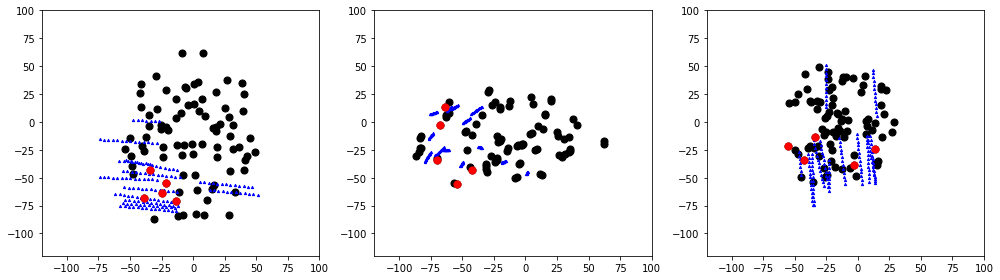

In [26]:
plt.figure(figsize=(14, 4))
plot_selected_nodes()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SelectedNodesandElectrodes.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SelectedNodesandElectrodes.eps"), doi=800)
plt.show()

In [27]:
nn=reg_xyz.shape[0]
ns=seeg_xyz.shape[0]

nn, ns

(84, 162)

In [28]:
dst=np.zeros((nn, ns))

In [29]:
from scipy.spatial import distance
for i in range(0, nn):
    for j in range(0, ns):
        dst[i,j] = distance.euclidean(reg_xyz[i,: ], seeg_xyz[j,: ])

In [30]:
dist_best=np.min(dst, axis=1)

In [31]:
dist_best.shape

(84,)

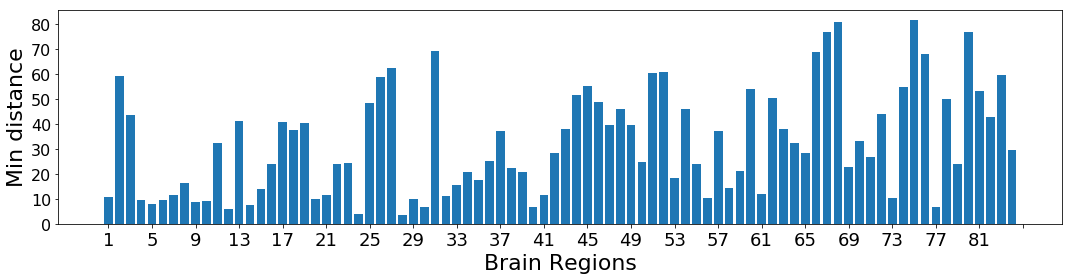

In [32]:
plt.figure(figsize=(15, 4))
plt.bar(np.r_[0:nn], dist_best)
plt.ylabel('Min distance',fontsize=22)
plt.xlabel('Brain Regions',fontsize=22)
plt.xticks(np.arange(0,nn+2, step=4),np.arange(1, nn+1, step=4), fontsize=18, rotation=0)
plt.yticks(fontsize=16, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"NodesDistances.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"NodesDistances.eps"), doi=800)
plt.show()

In [33]:
elecnames=[]
electrodes = {}  
with open(cwd+ '/ExperimentalData_CJ/elecs_name.txt', 'r') as fd:
            for i, line in enumerate(fd.readlines()):
                line = line.strip()
                contact, x, y, z = line.split()
                elecnames.append(contact)
                name, _ = re.match("([A-Za-z]+[']*)([0-9]+)", contact).groups()
                if name in electrodes:
                    electrodes[name].append(i)
                else:
                    electrodes[name] = [i]

In [34]:
from mpl_toolkits.mplot3d import axes3d, Axes3D

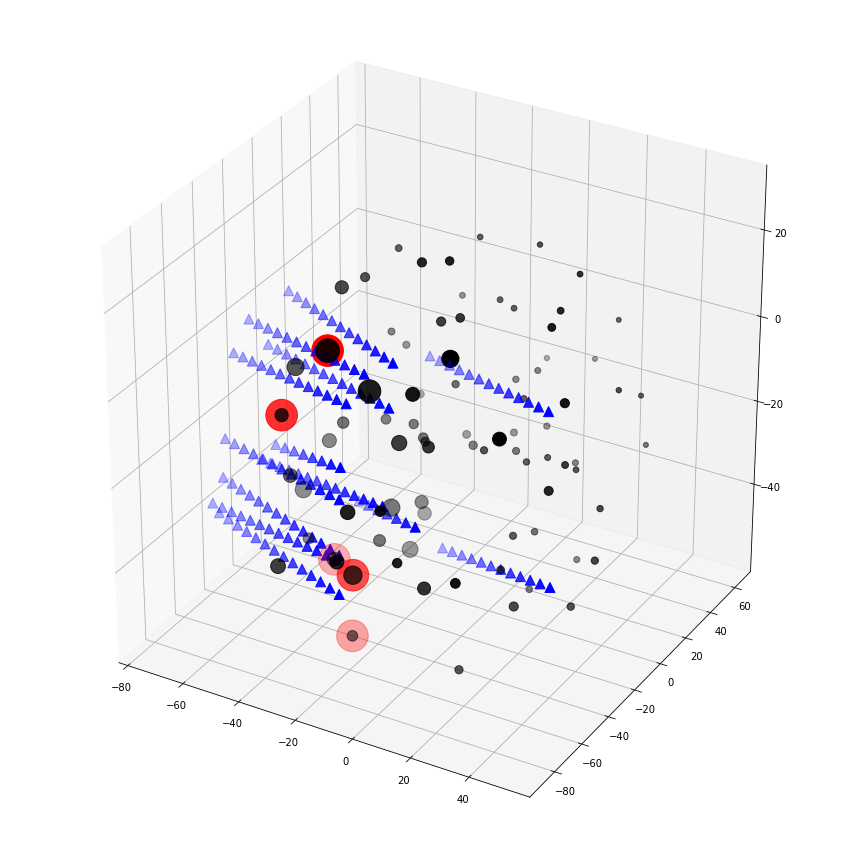

In [35]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reg_xyz [:, 0], reg_xyz [:, 1], reg_xyz [:, 2], color='k', s=2000./dist_best,  label='regions')
ax.scatter(r_selectednodes [:, 0], r_selectednodes [:, 1], r_selectednodes [:, 2], color='r', s=1000, label='selectedregions')
ax.scatter(r_selectedcontacts [:, 0], r_selectedcontacts [:, 1], r_selectedcontacts [:, 2], color='cyan',marker='^', s=300, label='selectecontacts')


for name, idxs in electrodes.items():
    ax.scatter(seeg_xyz [idxs, 0], seeg_xyz [idxs, 1], seeg_xyz [idxs, 2],marker='^', color='b', s=100, label=name)
    

#plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SelectedNodesandElectrodes3D.png"), doi=800)
#ax.view_init(-390, 30)

plt.show()    

### Simulator

In [36]:
from BVEP_Simulator import VEP2Dmodel

### some simulations for  sanity check

In [37]:
T = 14.0
dt=0.1
ts = np.arange(0, T + dt, dt)

In [38]:
nt=ts.shape[0]
nt

141

In [39]:
nn=SC.shape[0]
nn

84

In [40]:
Gr.shape

(162, 84)

In [41]:
ns=Gr.shape[0]
ns

162

In [42]:
tau=10.
sigma=5e-1
constants = np.array([tau, sigma])
constants

array([10. ,  0.5])

In [43]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [44]:
K_true=1.

In [45]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [46]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [47]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 2.8673343658447266


In [48]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 0.005415439605712891


In [49]:
X=Sim.reshape(nn, int(Sim.shape[0]/nn))
X.shape

(84, 141)

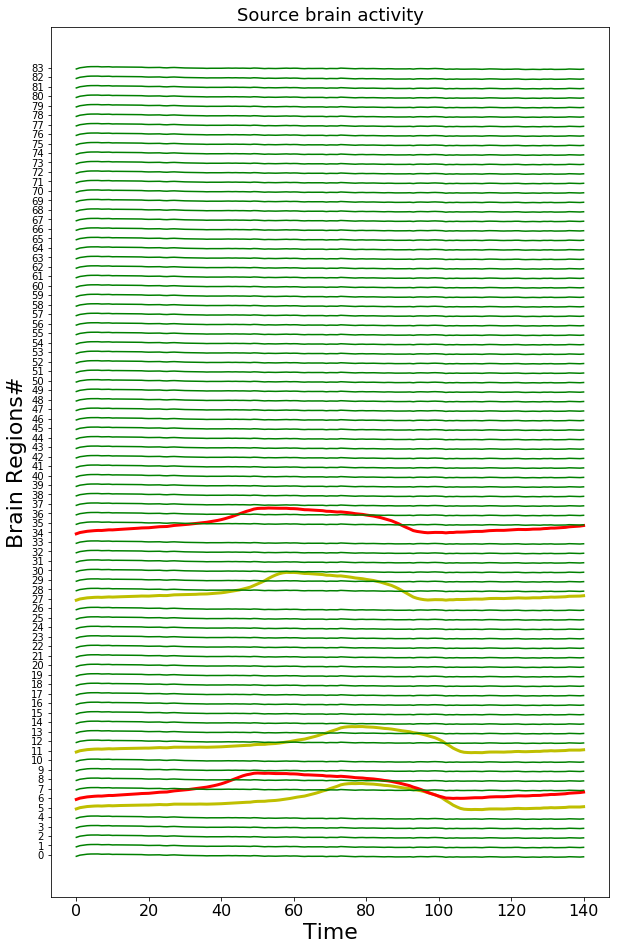

In [50]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(X[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(X[i,:]+i, 'y', lw=3)
    else:  
          plt.plot(X[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.show()

### Seeg signal

In [51]:
X.shape, Gr.shape

((84, 141), (162, 84))

In [52]:
Seeg= np.dot(Gr, np.exp(X))
Seeg.shape

(162, 141)

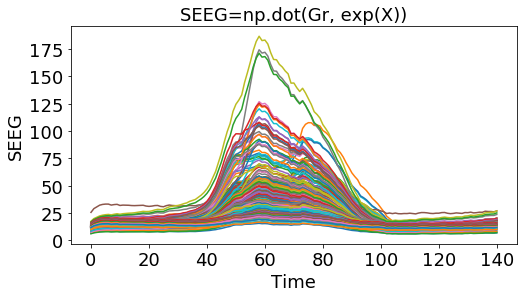

In [53]:
plt.figure(figsize=(8,4))
plt.plot(Seeg.T);
plt.xlabel('Time',fontsize=18)
plt.ylabel('SEEG',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("SEEG=np.dot(Gr, exp(X))",fontsize=18)
plt.show()

### Data

In [54]:
params_true

array([-3.65, -3.65, -3.65, -3.65, -3.65, -2.4 , -1.6 , -3.65, -3.65,
       -3.65, -3.65, -2.4 , -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
       -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
       -2.4 , -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -1.6 , -3.65,
       -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
       -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
       -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
       -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
       -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
       -3.65, -3.65, -3.65,  1.  ])

In [55]:
obs_source =VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
obs_source=obs_source.reshape(nn, int(obs_source.shape[0]/nn))

obs_seeg= np.dot(Gr, np.exp(obs_source))

In [56]:
obs_seeg.shape

(162, 141)

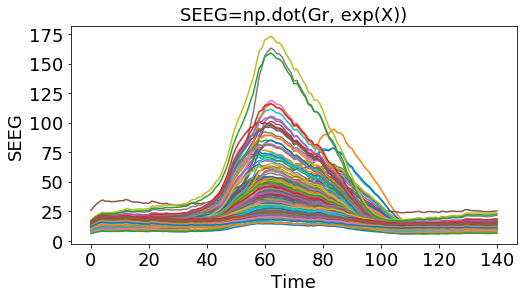

In [57]:
plt.figure(figsize=(8,4))
plt.plot(obs_seeg.T);
plt.xlabel('Time',fontsize=18)
plt.ylabel('SEEG',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("SEEG=np.dot(Gr, exp(X))",fontsize=18)
plt.show()

In [58]:
Num_data=obs_seeg.shape[0]*obs_seeg.shape[1]
Num_data

22842

### Sensitivity analysis

In [59]:
hz_val=-3.65
pz_val=-2.4
ez_val=-1.6

ez_idx = np.array([6, 34],  dtype=np.int32)
pz_wplng_idx = np.array([5,11], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [60]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [61]:
b=-7
a=0
incer=0.01

In [62]:
prior_range=np.arange(b,a,incer)

In [63]:
def Profile_likelihood(eta_true, K_true, prior_range, node_idx):
    params_true = np.append(eta_true, K_true)
    params_val=np.append(eta_true, K_true)
    
    Sweep_len=prior_range.shape[0]
    RMSE=np.zeros((Sweep_len))
    
    ii=0
    for i in prior_range:
        params_val[node_idx]=i
        y_source =VEP2Dmodel(params_val, constants, init_conditions, dt, ts, SC)
        y_source=y_source.reshape(nn, int(y_source.shape[0]/nn))
        y_seeg= np.dot(Gr, np.exp(y_source))
        RMSE[ii]=np.sqrt(np.sum((obs_seeg-y_seeg)**2)/Num_data)
        ii=ii+1
    return RMSE

In [64]:
ez_idx, pz_idx

(array([ 6, 34], dtype=int32), array([27,  5, 11], dtype=int32))

In [65]:
node_idx=ez_idx[0]

In [66]:
params_true[node_idx]

-1.6

In [67]:
RMSE_nodeidx_6=Profile_likelihood(eta_true, K_true, prior_range, node_idx=6)
RMSE_nodeidx_34=Profile_likelihood(eta_true, K_true, prior_range, node_idx=34)

In [68]:
len(ez_idx)

2

6
34


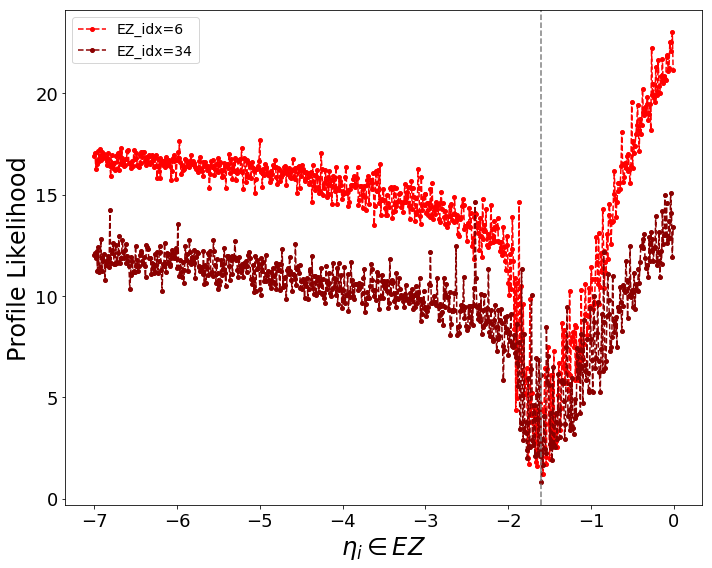

In [69]:
plt.figure(figsize=(10,8))

colours=['r', 'darkred']

for i in np.arange(len(ez_idx)):
    print(ez_idx[i])
    RMSE_nodeidx_=Profile_likelihood(eta_true, K_true, prior_range, node_idx=ez_idx[i])
    plt.plot(prior_range,RMSE_nodeidx_, '--o', label='EZ_idx='+str(ez_idx[i]), color=colours[i], markersize=4);
plt.axvline(x=ez_val, color='grey', linestyle='--')

plt.ylabel('Profile Likelihood',fontsize=24)
plt.xlabel('$\eta_i \in EZ$',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper left', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_EZ_config1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_EZ_config1.eps"), doi=800)
plt.show()

In [70]:
len(pz_idx)

3

27
5
11


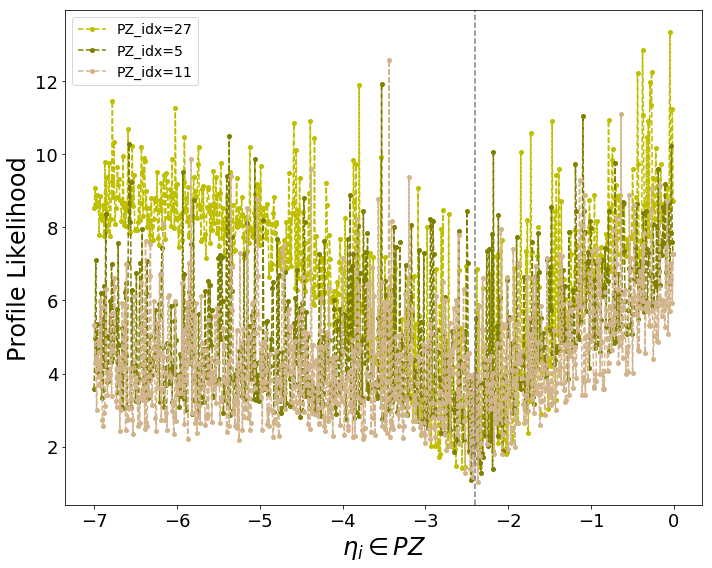

In [71]:
plt.figure(figsize=(10,8))

colours=['y', 'olive', 'tan']

for i in np.arange(len(pz_idx)):
    print(pz_idx[i])
    RMSE_nodeidx_=Profile_likelihood(eta_true, K_true, prior_range, node_idx=pz_idx[i])
    plt.plot(prior_range,RMSE_nodeidx_, '--o', label='PZ_idx='+str(pz_idx[i]), color=colours[i], markersize=4);
plt.axvline(x=pz_val, color='grey', linestyle='--')

plt.ylabel('Profile Likelihood',fontsize=24)
plt.xlabel('$\eta_i \in PZ$',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper left', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_PZ_config1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_PZ_config1.eps"), doi=800)
plt.show()

0
80


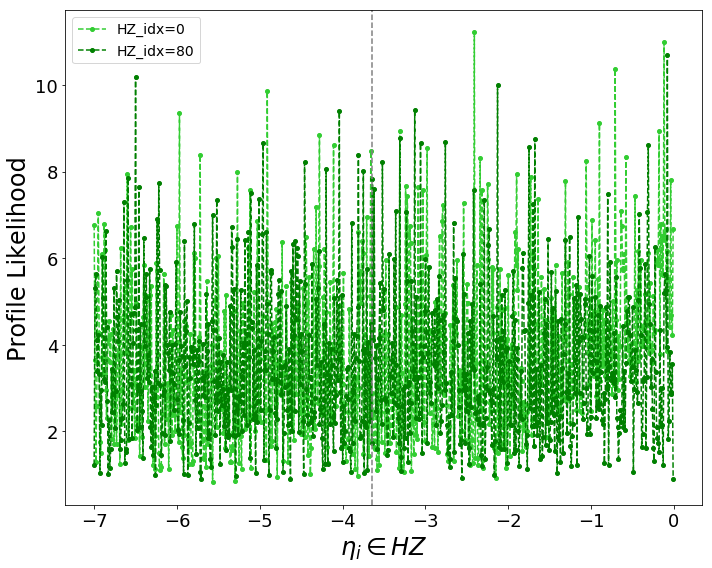

In [72]:
plt.figure(figsize=(10,8))

colours=['limegreen', 'green']

hz_idx_=[0,80]

for i in np.arange(len(hz_idx_)):
    print(hz_idx_[i])
    RMSE_nodeidx_=Profile_likelihood(eta_true, K_true, prior_range, node_idx=hz_idx_[i])
    plt.plot(prior_range,RMSE_nodeidx_, '--o', label='HZ_idx='+str(hz_idx_[i]), color=colours[i], markersize=4);
plt.axvline(x=hz_val, color='grey', linestyle='--')

plt.ylabel('Profile Likelihood',fontsize=24)
plt.xlabel('$\eta_i \in HZ$',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper left', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_HZ_config1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_HZ_config1.eps"), doi=800)
plt.show()

In [73]:
node_idx_true_val=[ez_val, pz_val, hz_val]
node_idx_true_val

[-1.6, -2.4, -3.65]

6
27
0


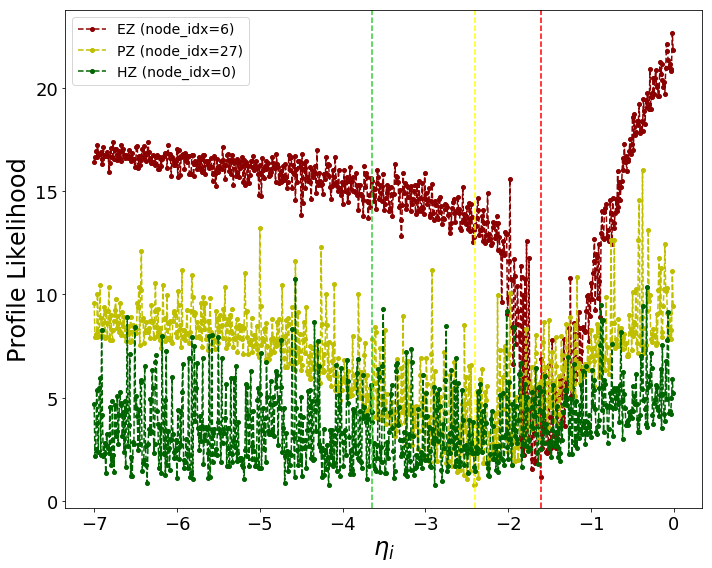

In [74]:
plt.figure(figsize=(10,8))

node_type_=['EZ', 'PZ', 'HZ']
colours=['darkred', 'y', 'darkgreen']
colours_=['red', 'yellow', 'limegreen']

node_idx_=[6,27, 0]
node_idx_true_val=[ez_val, pz_val, hz_val]

for i in np.arange(len(node_idx_)):
    print(node_idx_[i])
    RMSE_nodeidx_=Profile_likelihood(eta_true, K_true, prior_range, node_idx=node_idx_[i])
    plt.plot(prior_range,RMSE_nodeidx_, '--o', label=(str(node_type_[i]))+ ' ('+'node_idx='+str(node_idx_[i])+')', color=colours[i], markersize=4);
    plt.axvline(x=node_idx_true_val[i], color=colours_[i], linestyle='--')
    
plt.ylabel('Profile Likelihood',fontsize=24)
plt.xlabel('$\eta_i$',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper left', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_EZPZHZ_config1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_EZPZHZ_config1.eps"), doi=800)
plt.show()

6
27


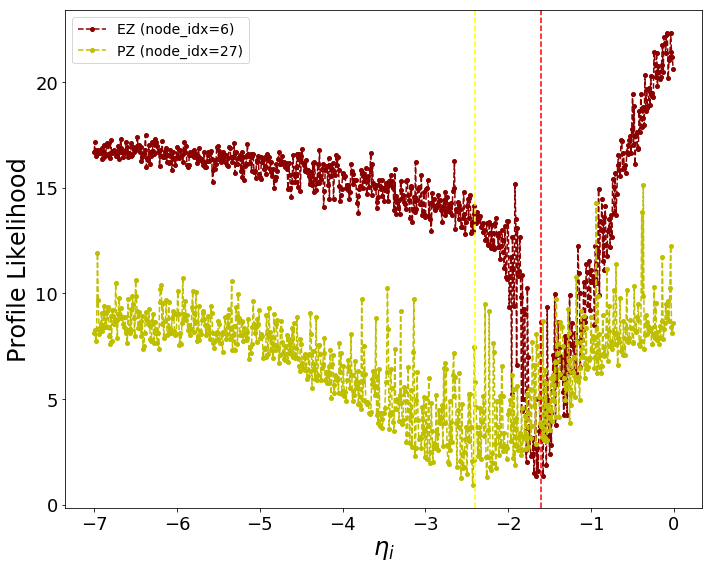

In [75]:
plt.figure(figsize=(10,8))

node_type_=['EZ', 'PZ']
colours=['darkred', 'y']
colours_=['red', 'yellow']

node_idx_=[6,27]
node_idx_true_val=[ez_val, pz_val]

for i in np.arange(len(node_idx_)):
    print(node_idx_[i])
    RMSE_nodeidx_=Profile_likelihood(eta_true, K_true, prior_range, node_idx=node_idx_[i])
    plt.plot(prior_range,RMSE_nodeidx_, '--o', label=(str(node_type_[i]))+ ' ('+'node_idx='+str(node_idx_[i])+')', color=colours[i], markersize=4);
    plt.axvline(x=node_idx_true_val[i], color=colours_[i], linestyle='--')
    
plt.ylabel('Profile Likelihood',fontsize=24)
plt.xlabel('$\eta_i$',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper left', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_EZPZ_config1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_EZPZ_config1.eps"), doi=800)
plt.show()

### 2D sweep

In [76]:
node_idx1=ez_idx[0]
node_idx2=ez_idx[1]

In [77]:
params_true = np.append(eta_true, K_true)
params_val=np.append(eta_true, K_true)
    
Sweep_len=prior_range.shape[0]
RMSE=np.zeros((Sweep_len, Sweep_len))
    
ii=-1
for i in prior_range:
    params_val[node_idx1]=i
    jj=-1
    ii=ii+1
    for j in prior_range:
        params_val[node_idx2]=j
        jj=jj+1
        y_source =VEP2Dmodel(params_val, constants, init_conditions, dt, ts, SC)
        y_source=y_source.reshape(nn, int(y_source.shape[0]/nn))
        y_seeg= np.dot(Gr, np.exp(y_source))
        RMSE[ii, jj]=np.sqrt(np.sum((obs_seeg-y_seeg)**2)/Num_data)

In [78]:
Sweep_len

700

In [79]:
x = np.linspace(b, a, Sweep_len)
y = np.linspace(b, a, Sweep_len)
X, Y = np.meshgrid(x, y)

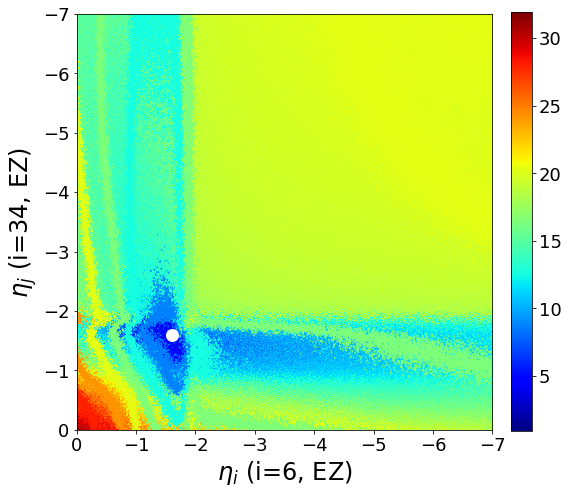

In [80]:
plt.figure(figsize=(8, 8))
plt.contour(Y, X, RMSE, cmap='jet');
plt.imshow((RMSE), interpolation='nearest', cmap='jet' ,extent=[b,a,a,b])
plt.plot(ez_val, ez_val, 'o', markersize=12, color='w')
cb = plt.colorbar(orientation="vertical", fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize=18)
#plt.title('Profile Likelihood', fontsize=28)
plt.xlabel(r'$\eta_i$ (i=6, EZ)',fontsize=24)
plt.ylabel(r'$\eta_j$ (i=34, EZ)',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.xaxis.set_ticks(prior_range[::10])
ax.yaxis.set_ticks(prior_range[::10])
plt.gca().invert_xaxis()
#ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
#ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_2DEZEZ_config1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_2DEZEZ_config1.eps"), doi=800)
plt.show()

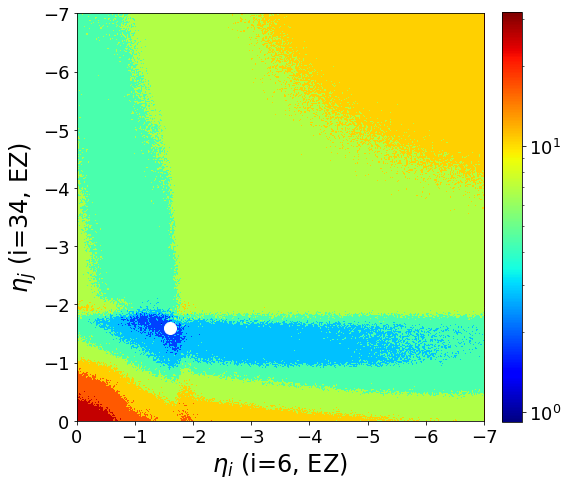

In [81]:
plt.figure(figsize=(8, 8))
plt.contourf(X, Y, (RMSE), cmap=cm.jet);
norm = colors.LogNorm(RMSE.min(), RMSE.max())
im = plt.imshow(RMSE,norm=norm,cmap=cm.jet, extent=[b,a,a,b])
plt.plot(ez_val, ez_val, 'o', markersize=12, color='w')
cb = plt.colorbar(orientation="vertical", fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize=18)
#plt.title('Profile Likelihood', fontsize=28)
plt.xlabel(r'$\eta_i$ (i=6, EZ)',fontsize=24)
plt.ylabel(r'$\eta_j$ (i=34, EZ)',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.xaxis.set_ticks(prior_range[::10])
ax.yaxis.set_ticks(prior_range[::10])
plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_contourf2DEZEZ_config1_log.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_contourf2DEZEZ_config1_log.eps"), doi=800)
plt.show()

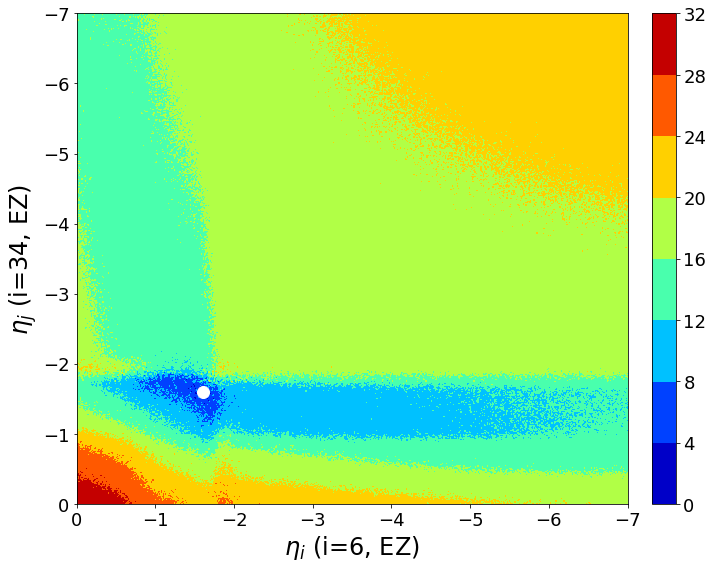

In [82]:
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, (RMSE), cmap=cm.jet);
#norm = colors.LogNorm(RMSE.min(), RMSE.max())
#im = plt.imshow(RMSE,norm=norm,cmap=cm.jet, extent=[b,a,a,b])
plt.plot(ez_val, ez_val, 'o', markersize=12, color='w')
cb = plt.colorbar(orientation="vertical", fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize=18)
#plt.title('Profile Likelihood', fontsize=28)
plt.xlabel(r'$\eta_i$ (i=6, EZ)',fontsize=24)
plt.ylabel(r'$\eta_j$ (i=34, EZ)',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.xaxis.set_ticks(prior_range[::10])
ax.yaxis.set_ticks(prior_range[::10])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_contourf2DEZEZ_config1_.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_contourf2DEZEZ_config1_.eps"), doi=800)
plt.show()

### Another SME

In [83]:
hz_val=-3.65
pz_val=-2.4
ez_val=-1.6

ez_idx = np.array([6, 34, 18, 45, 67, 81],  dtype=np.int32)
pz_wplng_idx = np.array([5,11], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [84]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

6
45
81
27


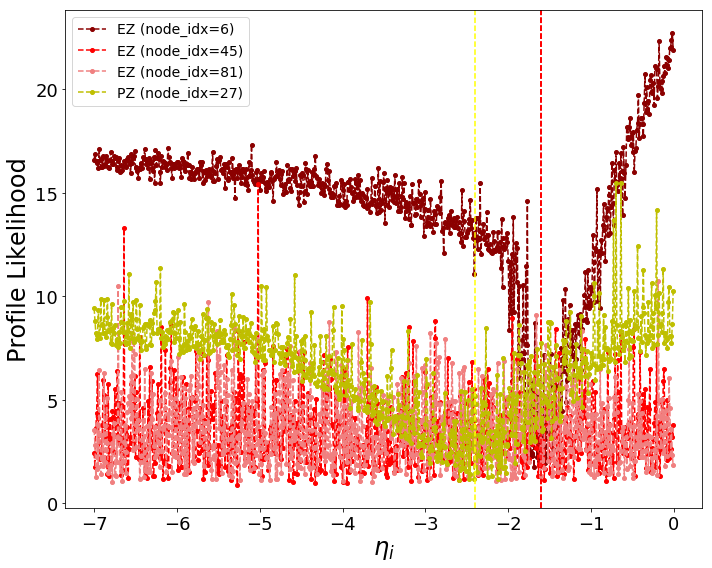

In [85]:
plt.figure(figsize=(10,8))

node_type_=['EZ', 'EZ', 'EZ', 'PZ']
colours=['darkred', 'red', 'lightcoral',  'y']
colours_=['r', 'r','r', 'yellow']

node_idx_=[6, 45, 81, 27]
node_idx_true_val=[ez_val, ez_val, ez_val, pz_val]

for i in np.arange(len(node_idx_)):
    print(node_idx_[i])
    RMSE_nodeidx_=Profile_likelihood(eta_true, K_true, prior_range, node_idx=node_idx_[i])
    plt.plot(prior_range,RMSE_nodeidx_, '--o', label=(str(node_type_[i]))+ ' ('+'node_idx='+str(node_idx_[i])+')', color=colours[i], markersize=4);
    plt.axvline(x=node_idx_true_val[i], color=colours_[i], linestyle='--')
    
plt.ylabel('Profile Likelihood',fontsize=24)
plt.xlabel('$\eta_i$',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper left', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_EZPZ_config2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_EZPZ_config2.eps"), doi=800)
plt.show()

### 2D sweep

In [86]:
pz_idx

array([27,  5, 11], dtype=int32)

In [87]:
node_idx1=ez_idx[-1]
node_idx2=ez_idx[-2]

In [88]:
node_idx1, node_idx2

(81, 67)

In [89]:
params_true = np.append(eta_true, K_true)
params_val=np.append(eta_true, K_true)
    
Sweep_len=prior_range.shape[0]
RMSE=np.zeros((Sweep_len, Sweep_len))
    
ii=-1
for i in prior_range:
    params_val[node_idx1]=i
    jj=-1
    ii=ii+1
    for j in prior_range:
        params_val[node_idx2]=j
        jj=jj+1
        y_source =VEP2Dmodel(params_val, constants, init_conditions, dt, ts, SC)
        y_source=y_source.reshape(nn, int(y_source.shape[0]/nn))
        y_seeg= np.dot(Gr, np.exp(y_source))
        RMSE[ii, jj]=np.sqrt(np.sum((obs_seeg-y_seeg)**2)/Num_data)

In [90]:
x = np.linspace(b, a, Sweep_len)
y = np.linspace(b, a, Sweep_len)
X, Y = np.meshgrid(x, y)

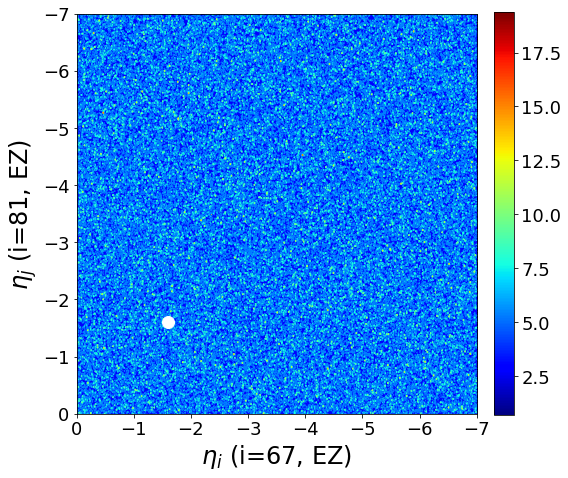

In [91]:
plt.figure(figsize=(8, 8))
plt.contour(Y, X, RMSE, cmap='jet');
plt.imshow((RMSE), interpolation='nearest', cmap='jet' ,extent=[b,a,a,b])
plt.plot(ez_val, ez_val, 'o', markersize=12, color='w')
cb = plt.colorbar(orientation="vertical", fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize=18)
#plt.title('Profile Likelihood', fontsize=28)
plt.xlabel(r'$\eta_i$ (i=67, EZ)',fontsize=24)
plt.ylabel(r'$\eta_j$ (i=81, EZ)',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.xaxis.set_ticks(prior_range[::10])
ax.yaxis.set_ticks(prior_range[::10])
plt.gca().invert_xaxis()
#ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
#ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_2DEZEZ_config2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_2DEZEZ_config2.eps"), doi=800)
plt.show()

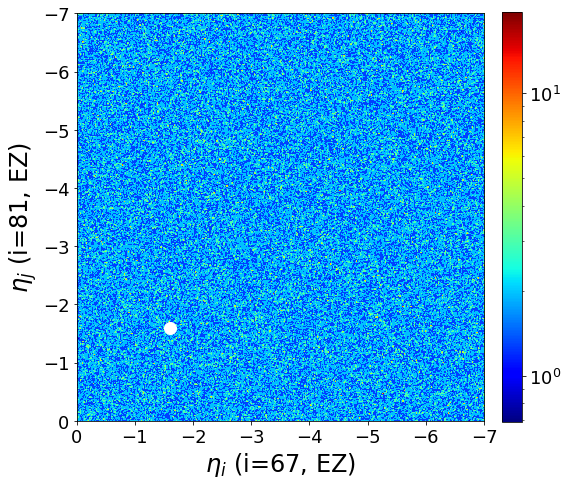

In [92]:
plt.figure(figsize=(8, 8))
plt.contourf(X, Y, (RMSE), cmap='jet');
norm = colors.LogNorm(RMSE.min(), RMSE.max())
im = plt.imshow(RMSE,norm=norm,cmap=cm.jet, extent=[b,a,a,b])
plt.plot(ez_val, ez_val, 'o', markersize=12, color='w')
cb = plt.colorbar(orientation="vertical", fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize=18)
#plt.title('Profile Likelihood', fontsize=28)
plt.xlabel(r'$\eta_i$ (i=67, EZ)',fontsize=24)
plt.ylabel(r'$\eta_j$ (i=81, EZ)',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.xaxis.set_ticks(prior_range[::10])
ax.yaxis.set_ticks(prior_range[::10])
plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_contourf2DEZEZ_config2_log.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_contourf2DEZEZ_config2_log.eps"), doi=800)
plt.show()

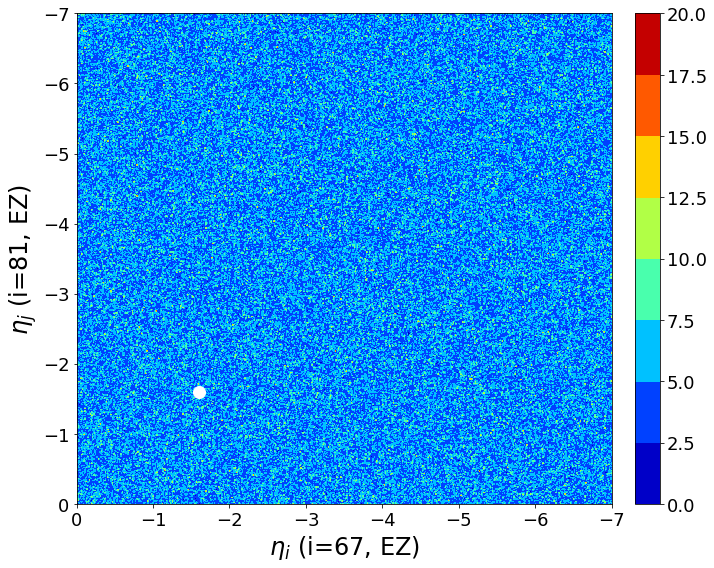

In [93]:
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, (RMSE), cmap='jet');
#norm = colors.LogNorm(RMSE.min(), RMSE.max())
#im = plt.imshow(RMSE,norm=norm,cmap=cm.jet, extent=[b,a,a,b])
plt.plot(ez_val, ez_val, 'o', markersize=12, color='w')
cb = plt.colorbar(orientation="vertical", fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize=18)
#plt.title('Profile Likelihood', fontsize=28)
plt.xlabel(r'$\eta_i$ (i=67, EZ)',fontsize=24)
plt.ylabel(r'$\eta_j$ (i=81, EZ)',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.xaxis.set_ticks(prior_range[::10])
ax.yaxis.set_ticks(prior_range[::10])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_contourf2DEZEZ_config2_.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ProfileLikelihood_contourf2DEZEZ_config2_.eps"), doi=800)
plt.show()